In [34]:
pip install --upgrade xlsxwriter

Note: you may need to restart the kernel to use updated packages.


In [35]:
pip install xlsxwriter

Note: you may need to restart the kernel to use updated packages.


In [40]:
import pandas as pd
# Load the Excel file
workbook = pd.ExcelFile("Trade.xlsx")

# Read the worksheets into separate dataframes
df_sheet1 = pd.read_excel(workbook, sheet_name="Table A0 2013-2020", header=None)
df_sheet2 = pd.read_excel(workbook, sheet_name="Table A0 2021", header=None)

# Delete top 2 rows in each worksheet
df_sheet1= df_sheet1.drop(index=range(2))
df_sheet2= df_sheet2.drop(index=range(2))

# Promote row 1 to header in each worksheet
new_header = df_sheet1.iloc[0]
df_sheet1 = df_sheet1[1:]
df_sheet1.columns = new_header

new_header = df_sheet2.iloc[0]
df_sheet2 = df_sheet2[1:]
df_sheet2.columns = new_header

# Remove all rows in which column A starts with "Total"
df_sheet1 = df_sheet1[~df_sheet1["Continent"].str.startswith("Total")]
df_sheet2 = df_sheet2[~df_sheet2["Continent"].str.startswith("Total")]

# Remove all rows in which column B starts with "Total"
df_sheet1 = df_sheet1[~df_sheet1["Region"].str.startswith("Total")]
df_sheet2 = df_sheet2[~df_sheet2["Region"].str.startswith("Total")]

# Remove all rows in which column C starts with "Total"
df_sheet1 = df_sheet1[~df_sheet1["Country"].str.startswith("Total")]
df_sheet2 = df_sheet2[~df_sheet2["Country"].str.startswith("Total")]

# identify the columns to drop, those column headers starting with the word "balance"
balance_cols_1 = [col for col in df_sheet1.columns if col.startswith('Balance')]
balance_cols_2 = [col for col in df_sheet2.columns if col.startswith('Balance')]

# drop the columns in both worksheets
df_sheet1.drop(columns=balance_cols_1, inplace=True)
df_sheet2.drop(columns=balance_cols_2, inplace=True)

# delete International Organsiaiton as figures are either showing as 0 or suppressed
# filter out rows where Country column contains "International Organisation"
mask_1 = ~df_sheet1['Country'].str.contains('International Organisation')
df_sheet1 = df_sheet1[mask_1]
mask_2 = ~df_sheet2['Country'].str.contains('International Organisation')
df_sheet2 = df_sheet2[mask_2]

# replace "Suppressed" with 0
df_sheet1 = df_sheet1.replace('Suppressed', 0)
df_sheet2 = df_sheet2.replace('Suppressed', 0)

In [41]:
''' In order to achieve consistency in the naming of countries across the 2 worksheets so that a Vlookup 
can be performed correctly'''

# Replace "France (Including Monaco)" with "France" in the "Country" column for Table A0 2021 worksheet
df_sheet2['Country'] = df_sheet2['Country'].replace('France (Including Monaco)', 'France')

# Replace "United States (Including Puerto Rico)" with "USA" in the "Country" column for  Table A0 2021 worksheet
df_sheet2['Country'] = df_sheet2['Country'].replace('United States (Including Puerto Rico)', 'USA')

# Replace "Other Countries (Or World) Unallocated" with "Total Unallocated" in the "Country" for Table A0 2021 worksheet
df_sheet2['Country'] = df_sheet2['Country'].replace('Other Countries (Or World) Unallocated', 'Total Unallocated')

# Delete rows containing "Polar Regions Unallocated" in the "Country" column for Table A0 2021 worksheet
df_sheet2 = df_sheet2[df_sheet2['Country'] != 'Polar Regions Unallocated']


In [42]:
# Perform the VLOOKUP by merging the two dataframes based on a common column
merged_df = pd.merge(df_sheet1, df_sheet2, on=['Country', 'Region', 'Continent'])

# Save the merged dataframe to a new file
merged_df.to_csv('merged_file.csv', index=False)

In [43]:
merged_df.head()

2,Continent,Region,Country,Exports 2013,Exports 2014,Exports 2015,Exports 2016,Exports 2017,Exports 2018,Exports 2019,...,Imports 2013,Imports 2014,Imports 2015,Imports 2016,Imports 2017,Imports 2018,Imports 2019,Imports 2020,Exports 2021,Imports 2021
0,Europe,European Union (EU),Austria,365,373,388,482,887,2017,1499.0,...,245,380,345,355,444,548,690,526,737,565
1,Europe,European Union (EU),Belgium,2064,1730,2078,2516,3292,3271,3646.0,...,1199,1010,1264,1331,1350,1416,1569,1813,4130,1363
2,Europe,European Union (EU),Bulgaria,93,96,159,137,132,180,158.0,...,87,57,89,138,176,226,290,419,205,353
3,Europe,European Union (EU),Croatia,45,55,53,72,133,162,106.0,...,25,16,21,23,44,41,84,56,99,69
4,Europe,European Union (EU),Cyprus,456,230,287,413,435,411,531.0,...,285,141,181,135,137,225,200,200,663,183


In [44]:
# melt the DataFrame
melted_df = merged_df.melt(id_vars=['Continent','Region','Country'], var_name='Year', value_name='Value')
melted_df.head()

,Continent,Region,Country,Year,Value
0,Europe,European Union (EU),Austria,Exports 2013,365.0
1,Europe,European Union (EU),Belgium,Exports 2013,2064.0
2,Europe,European Union (EU),Bulgaria,Exports 2013,93.0
3,Europe,European Union (EU),Croatia,Exports 2013,45.0
4,Europe,European Union (EU),Cyprus,Exports 2013,456.0


In [45]:
# Split the 'Year' column into two columns using spaces as delimiter
melted_df[['Type', 'Year_']] = melted_df['Year'].str.split(' ', n=1, expand=True)

# Drop the original 'Column' column
df_sheet_cleaned = melted_df.drop('Year', axis=1)
df_sheet_cleaned.head()

,Continent,Region,Country,Value,Type,Year_
0,Europe,European Union (EU),Austria,365.0,Exports,2013
1,Europe,European Union (EU),Belgium,2064.0,Exports,2013
2,Europe,European Union (EU),Bulgaria,93.0,Exports,2013
3,Europe,European Union (EU),Croatia,45.0,Exports,2013
4,Europe,European Union (EU),Cyprus,456.0,Exports,2013


In [46]:
# Split the DataFrame into two based on 'Type'
grouped = df_sheet_cleaned.groupby('Type')

# Save the split DataFrames as separate CSV files (called Imports and Exports)
for name, group in grouped:
    group.to_csv(name + '.csv', index=False)

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import plotly.graph_objects as go
warnings.filterwarnings("ignore")
import squarify
# If using notebook, you need this to display plots
%matplotlib inline 
# Read the CSV file
df_import = pd.read_csv('Imports.csv')
df_import

,Continent,Region,Country,Value,Type,Year_
0,Europe,European Union (EU),Austria,245.0,Imports,2013
1,Europe,European Union (EU),Belgium,1199.0,Imports,2013
2,Europe,European Union (EU),Bulgaria,87.0,Imports,2013
3,Europe,European Union (EU),Croatia,25.0,Imports,2013
4,Europe,European Union (EU),Cyprus,285.0,Imports,2013
...,...,...,...,...,...,...
598,"Australasia, Oceania and Polar Regions","Australasia, Oceania And Polar Regions",Oceania Unallocated,0.0,Imports,2021
599,Africa,Africa,Nigeria,686.0,Imports,2021
600,Africa,Africa,South Africa,498.0,Imports,2021
601,Africa,Africa,Rest Of Africa,0.0,Imports,2021


In [49]:
# For the import file
# Group the data by country and year, and calculate the sum of values
grouped_1 = df_import.groupby(['Country', 'Year_'])['Value'].sum()

# Calculate the total value for each year
total_per_year = grouped_1.groupby('Year_').transform('sum')

# Calculate the percentage per country based on the total value for each year
percentage_per_country = 100 * grouped_1 / total_per_year

# Reset the index to turn the grouped Series back into a DataFrame
percentage_per_country = percentage_per_country.reset_index()

# Merge the percentage_per_country DataFrame with the original DataFrame
df_import_1 = pd.merge(df_import, percentage_per_country, on=['Country', 'Year_'], suffixes=('', ' % country'))

# Group the data by Region and year, and calculate the sum of values
grouped_2 = df_import_1.groupby(['Region', 'Year_'])['Value'].sum()

# Calculate the total value for each year
total_per_year = grouped_2.groupby('Year_').transform('sum')

# Calculate the percentage per Region based on the total value for each year
percentage_per_region = 100 * grouped_2 / total_per_year

# Reset the index to turn the grouped Series back into a DataFrame
percentage_per_region = percentage_per_region.reset_index()

# Merge the percentage_per_country DataFrame with the original DataFrame
df_import_2 = pd.merge(df_import_1, percentage_per_region, on=['Region', 'Year_'], suffixes=('', ' % region'))

# Print the resulting DataFrame
df_import_2

,Continent,Region,Country,Value,Type,Year_,Value % country,Value % region
0,Europe,European Union (EU),Austria,245.0,Imports,2013,0.470557,46.725310
1,Europe,European Union (EU),Belgium,1199.0,Imports,2013,2.302846,46.725310
2,Europe,European Union (EU),Bulgaria,87.0,Imports,2013,0.167096,46.725310
3,Europe,European Union (EU),Croatia,25.0,Imports,2013,0.048016,46.725310
4,Europe,European Union (EU),Cyprus,285.0,Imports,2013,0.547382,46.725310
...,...,...,...,...,...,...,...,...
598,"Australasia, Oceania and Polar Regions","Australasia, Oceania And Polar Regions",Oceania Unallocated,0.0,Imports,2021,0.000000,1.290854
599,Africa,Africa,Nigeria,686.0,Imports,2021,0.564748,0.974726
600,Africa,Africa,South Africa,498.0,Imports,2021,0.409978,0.974726
601,Africa,Africa,Rest Of Africa,0.0,Imports,2021,0.000000,0.974726


In [50]:
# Read the CSV file
df_export = pd.read_csv('Exports.csv')
df_export

,Continent,Region,Country,Value,Type,Year_
0,Europe,European Union (EU),Austria,365.0,Exports,2013
1,Europe,European Union (EU),Belgium,2064.0,Exports,2013
2,Europe,European Union (EU),Bulgaria,93.0,Exports,2013
3,Europe,European Union (EU),Croatia,45.0,Exports,2013
4,Europe,European Union (EU),Cyprus,456.0,Exports,2013
...,...,...,...,...,...,...
598,"Australasia, Oceania and Polar Regions","Australasia, Oceania And Polar Regions",Oceania Unallocated,0.0,Exports,2021
599,Africa,Africa,Nigeria,443.0,Exports,2021
600,Africa,Africa,South Africa,1364.0,Exports,2021
601,Africa,Africa,Rest Of Africa,2408.0,Exports,2021


In [52]:
# For the export file
# Group the data by country and year, and calculate the sum of values
grouped_1 = df_export.groupby(['Country', 'Year_'])['Value'].sum()

# Calculate the total value for each year
total_per_year = grouped_1.groupby('Year_').transform('sum')

# Calculate the percentage per country based on the total value for each year
percentage_per_country = 100 * grouped_1 / total_per_year

# Reset the index to turn the grouped Series back into a DataFrame
percentage_per_country = percentage_per_country.reset_index()

# Merge the percentage_per_country DataFrame with the original DataFrame
df_export_1 = pd.merge(df_export, percentage_per_country, on=['Country', 'Year_'], suffixes=('', ' % country'))

# Group the data by Region and year, and calculate the sum of values
grouped_2 = df_export_1.groupby(['Region', 'Year_'])['Value'].sum()

# Calculate the total value for each year
total_per_year = grouped_2.groupby('Year_').transform('sum')

# Calculate the percentage per Region based on the total value for each year
percentage_per_region = 100 * grouped_2 / total_per_year

# Reset the index to turn the grouped Series back into a DataFrame
percentage_per_region = percentage_per_region.reset_index()

# Merge the percentage_per_country DataFrame with the original DataFrame
df_export_2 = pd.merge(df_export_1, percentage_per_region, on=['Region', 'Year_'], suffixes=('', ' % region'))

# Print the resulting DataFrame
df_export_2

,Continent,Region,Country,Value,Type,Year_,Value % country,Value % region
0,Europe,European Union (EU),Austria,365.0,Exports,2013,0.324165,36.491203
1,Europe,European Union (EU),Belgium,2064.0,Exports,2013,1.833086,36.491203
2,Europe,European Union (EU),Bulgaria,93.0,Exports,2013,0.082595,36.491203
3,Europe,European Union (EU),Croatia,45.0,Exports,2013,0.039966,36.491203
4,Europe,European Union (EU),Cyprus,456.0,Exports,2013,0.404984,36.491203
...,...,...,...,...,...,...,...,...
598,"Australasia, Oceania and Polar Regions","Australasia, Oceania And Polar Regions",Oceania Unallocated,0.0,Exports,2021,0.000000,2.197818
599,Africa,Africa,Nigeria,443.0,Exports,2021,0.208264,2.070885
600,Africa,Africa,South Africa,1364.0,Exports,2021,0.641246,2.070885
601,Africa,Africa,Rest Of Africa,2408.0,Exports,2021,1.132052,2.070885


In [53]:
# Check for null in the import 
df_import_2.isnull().sum()

Continent          0
Region             0
Country            0
Value              0
Type               0
Year_              0
Value % country    0
Value % region     0
dtype: int64

In [54]:
# Check for null in the export 
df_export_2.isnull().sum()

Continent          0
Region             0
Country            0
Value              0
Type               0
Year_              0
Value % country    0
Value % region     0
dtype: int64

In [101]:
# Check for duplicate row for import and export
print("Duplicate imports : "+str(df_import_2.duplicated().sum()))
print("Duplicate exports : "+str(df_export_2.duplicated().sum()))

Duplicate imports : 0
Duplicate exports : 0


In [55]:
# Check type of data in import
df_import_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 603 entries, 0 to 602
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Continent        603 non-null    object 
 1   Region           603 non-null    object 
 2   Country          603 non-null    object 
 3   Value            603 non-null    float64
 4   Type             603 non-null    object 
 5   Year_            603 non-null    int64  
 6   Value % country  603 non-null    float64
 7   Value % region   603 non-null    float64
dtypes: float64(3), int64(1), object(4)
memory usage: 42.4+ KB


In [56]:
# Check type of data in export
df_export_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 603 entries, 0 to 602
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Continent        603 non-null    object 
 1   Region           603 non-null    object 
 2   Country          603 non-null    object 
 3   Value            603 non-null    float64
 4   Type             603 non-null    object 
 5   Year_            603 non-null    int64  
 6   Value % country  603 non-null    float64
 7   Value % region   603 non-null    float64
dtypes: float64(3), int64(1), object(4)
memory usage: 42.4+ KB


In [102]:
print("No of Country were import trade in services are "+str(len(df_import_2['Country'].unique())))
print("No of Country were export trade in services are "+str(len(df_export_2['Country'].unique())))

No of Country were import trade in services are 67
No of Country were export trade in services are 67


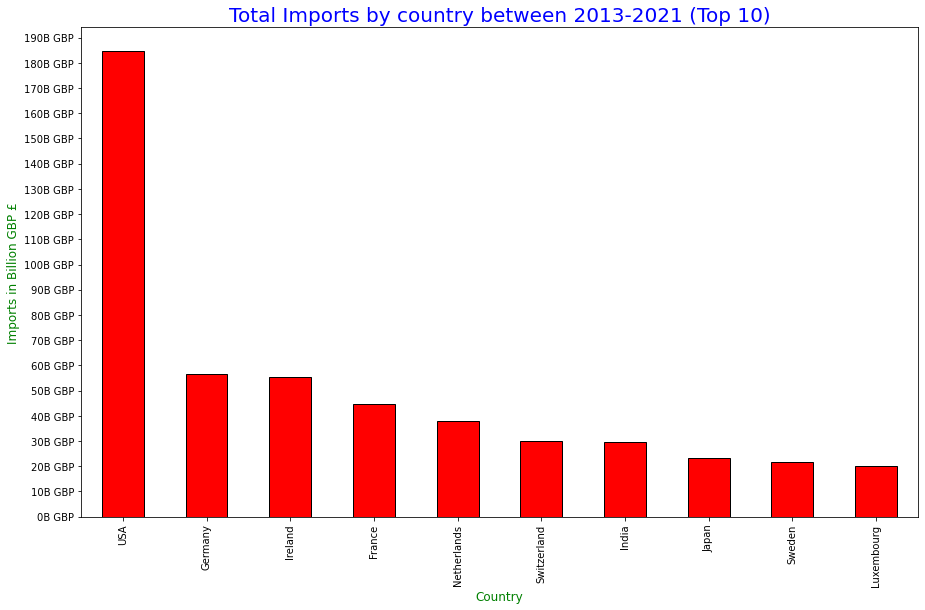

In [72]:
### To which country UK imported highest (from 2013 to 2021)? (top 10)
plt.figure(figsize=[15,9])
a=df_import_2.groupby(by=['Country'])['Value'].sum().sort_values(ascending=False).head(10)
a.plot(kind='bar',color='red',edgecolor='black')
plt.xlabel('Country',fontdict={'fontsize': 12,'color':'green'})
plt.ylabel('Imports in Billion GBP £',fontdict={'fontsize': 12,'color':'green'})
plt.title('Total Imports by country between 2013-2021 (Top 10)',fontdict={'fontsize': 20,'color':'Blue'})
ticks = np.arange(0, 200000, 10000)
labels = ["{}B GBP".format(i//1000) for i in ticks]
plt.yticks(ticks, labels)
plt.show()

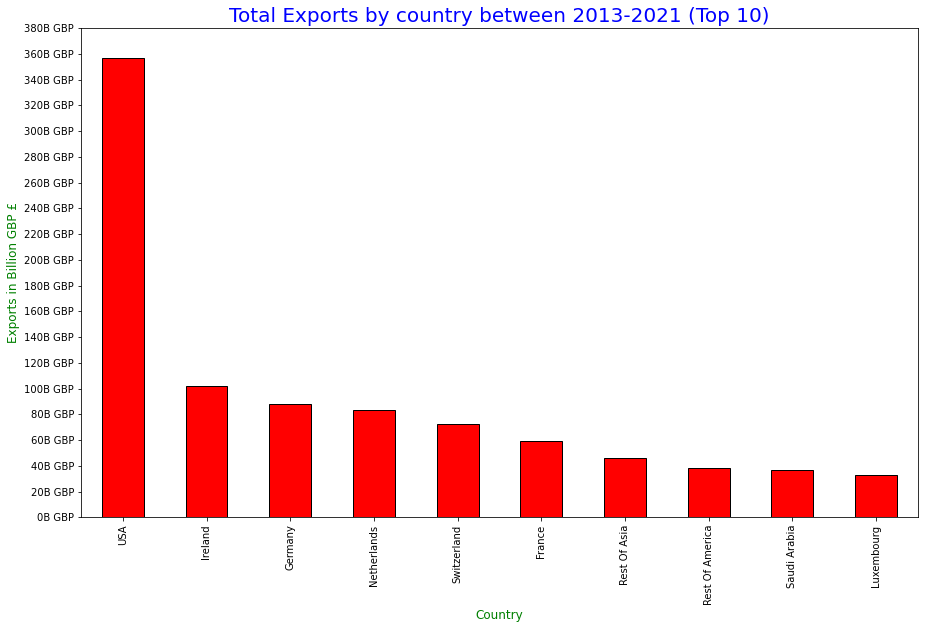

In [77]:
### To which country UK exported highest (from 2013 to 2021)? (top 10)
plt.figure(figsize=[15,9])
a=df_export_2.groupby(by=['Country'])['Value'].sum().sort_values(ascending=False).head(10)
a.plot(kind='bar',color='red',edgecolor='black')
plt.xlabel('Country',fontdict={'fontsize': 12,'color':'green'})
plt.ylabel('Exports in Billion GBP £',fontdict={'fontsize': 12,'color':'green'})
plt.title('Total Exports by country between 2013-2021 (Top 10)',fontdict={'fontsize': 20,'color':'Blue'})
ticks = np.arange(0, 400000, 20000)
labels = ["{}B GBP".format(i//1000) for i in ticks]
plt.yticks(ticks, labels)
plt.show()

In [105]:
df5 = df_import_2.groupby('Country').agg({'Value':'sum'})
df5 = df5.sort_values(by='Value', ascending = False)
df5 = df5[:10]
df6 = df_export_2.groupby('Country').agg({'Value':'sum'})
df6 = df6.sort_values(by='Value', ascending = False)
df6 = df6[:10]

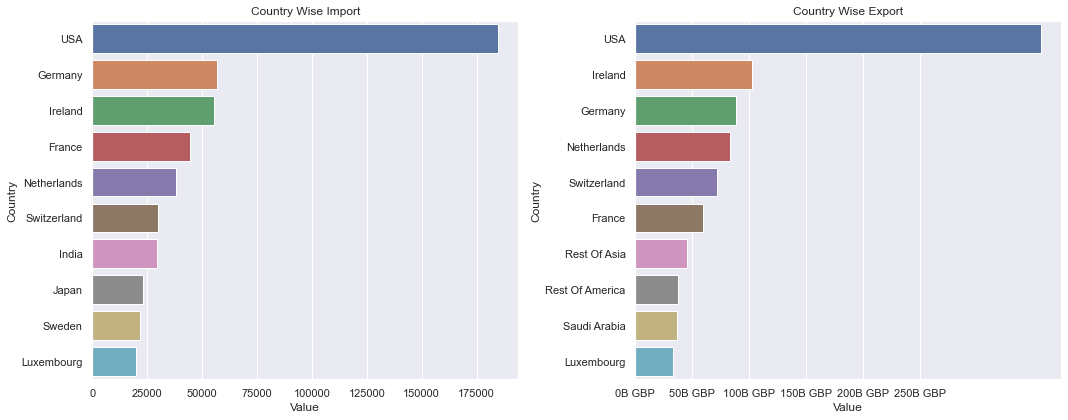

In [108]:
sns.set(rc={'figure.figsize':(15,6)})
ax1 = plt.subplot(121)
sns.barplot(df5.Value,df5.index).set_title('Country Wise Import')
ax2 = plt.subplot(122)
sns.barplot(df6.Value,df6.index).set_title('Country Wise Export')
ticks = np.arange(0, 300000, 50000)
labels = ["{}B GBP".format(i//1000) for i in ticks]
plt.xticks(ticks, labels)
plt.tight_layout()
plt.show()

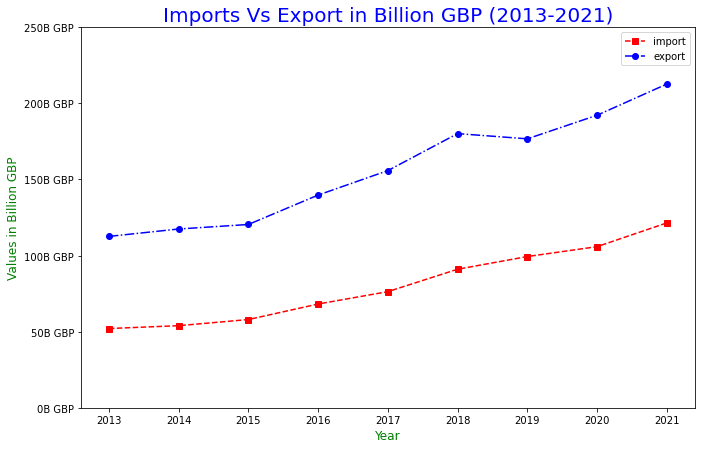

In [80]:
### We can compare Import Vs. Export during 2013-2021
plt.figure(figsize=[11,7])
df_import_2.groupby(by='Year_')['Value'].sum().plot.line(color='red',marker='s',linestyle='--',label='import')
df_export_2.groupby(by='Year_')['Value'].sum().plot.line(color='blue',marker='o',linestyle='-.',label='export')
ticks = np.arange(0, 300000, 50000)
labels = ["{}B GBP".format(i//1000) for i in ticks]
plt.yticks(ticks, labels)
plt.xlabel('Year',fontdict={'fontsize': 12,'color':'green'})
plt.ylabel('Values in Billion GBP',fontdict={'fontsize': 12,'color':'green'})
plt.title('Imports Vs Export in Billion GBP (2013-2021)',fontdict={'fontsize': 20,'color':'Blue'})
plt.legend()
plt.show()

In [83]:
# Net exporter in any Year?
# Biggest exporter is in Year 2021, smallest exportere is in Year 2013
x=df_import_2.groupby(by='Year_')['Value'].sum()
y=df_export_2.groupby(by='Year_')['Value'].sum()
print(min(y-x))
print(max(y-x))
print(y-x)

60531.0
91241.0
Year_
2013    60531.00000
2014    63512.00000
2015    62459.00000
2016    71573.00000
2017    79529.00000
2018    89096.00000
2019    77343.53441
2020    86331.00000
2021    91241.00000
Name: Value, dtype: float64


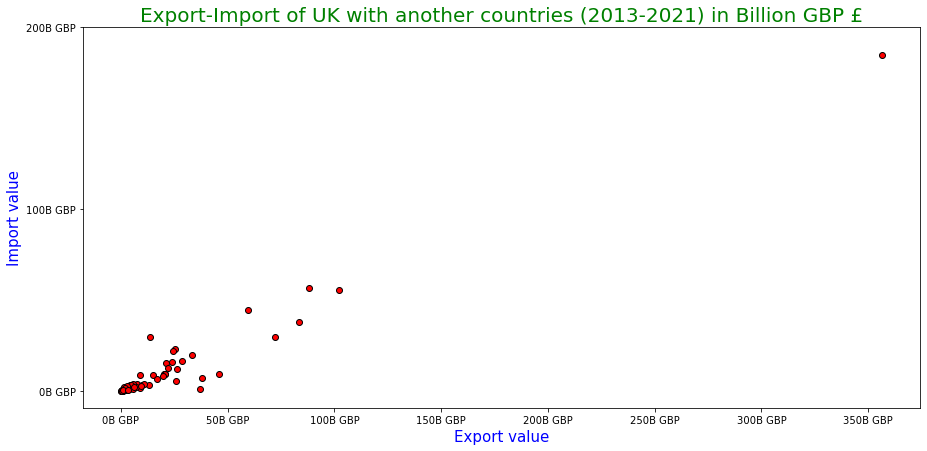

In [93]:
### Grouping countries for export data and import data
df1=df_export_2.groupby(by='Country')['Value'].sum()
df2=df_import_2.groupby(by='Country')['Value'].sum()
### Merging data frame on country
df3=pd.merge(df1,df2,on='Country')
df3.rename(columns={'Value_x':'export_val','Value_y':'import_val'},inplace=True)
df3.head()
## Plot scatter graph to show any correlation between export and import to another countries
plt.figure(figsize=[15,7])
plt.scatter(df3.export_val,df3.import_val,marker='o',edgecolor='black',color='red')
plt.ylabel('Import value',fontdict={'fontsize':15,'color':'blue'})
plt.xlabel('Export value',fontdict={'fontsize':15,'color':'blue'})
ticks_y = np.arange(0, 300000, 100000)
ticks_x = np.arange(0, 400000, 50000)
labels_y = ["{}B GBP".format(i//1000) for i in ticks_y]
labels_x = ["{}B GBP".format(i//1000) for i in ticks_x]
plt.yticks(ticks_y, labels_y)
plt.xticks(ticks_x, labels_x)
plt.title('Export-Import of UK with another countries (2013-2021) in Billion GBP £',fontdict={'fontsize':20,'color':'green'})
plt.show()

In [95]:
### Making a column for trade difference to find out with which country UK has been a net exoprter and with a net importer?
df3['trade_diff']=df3['export_val']-df3['import_val']
df3

,export_val,import_val,trade_diff
Country,,,
Africa Unallocated,2267.0,1333.0,934.0
America Unallocated,2401.0,445.0,1956.0
Asia Unallocated,8964.0,1816.0,7148.0
Australia,20774.0,9116.0,11658.0
Austria,7592.0,4098.0,3494.0
...,...,...,...
Switzerland,72154.0,29896.0,42258.0
Taiwan,5452.0,1335.0,4117.0
Thailand,3124.0,796.0,2328.0


<Figure size 1008x576 with 0 Axes>

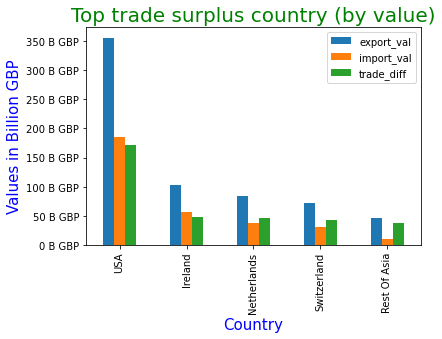

In [97]:
### Which are top 5 countries to which UK exports more and imoprt less?
plt.figure(figsize=[14,8])
top5=df3.sort_values(by='trade_diff',ascending=False).head(5)
top5.plot(kind='bar')
ticks = np.arange(0, 400000, 50000)
labels = ["{} B GBP".format(i//1000) for i in ticks]
plt.yticks(ticks, labels)
plt.title('Top 5 trade surplus country (by value)',fontdict={'fontsize':20,'color':'green'})
plt.ylabel('Values in Billion GBP',fontdict={'fontsize':15,'color':'blue'})
plt.xlabel('Country',fontdict={'fontsize':15,'color':'blue'})
plt.show()

<Figure size 792x504 with 0 Axes>

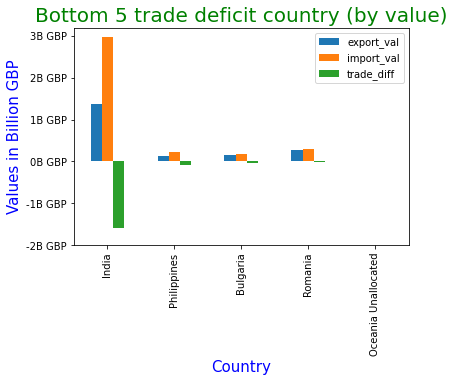

In [100]:
### Which are top 5 countries to which UK imports more and export less?
plt.figure(figsize=[11,7])
bottom5=df3.sort_values(by='trade_diff',ascending=True).head(5)
bottom5.plot(kind='bar')
ticks = np.arange(-20000, 40000, 10000)
labels = ["{}B GBP".format(i//10000) for i in ticks]
plt.yticks(ticks, labels)
plt.title('Bottom 5 trade deficit country (by value)',fontdict={'fontsize':20,'color':'green'})
plt.ylabel('Values in Billion GBP',fontdict={'fontsize':15,'color':'blue'})
plt.xlabel('Country',fontdict={'fontsize':15,'color':'blue'})
plt.show()